# Modeling a Zombie Apocalypse in PySB

## Credits
* Zombie Apocalypse example by [Munz et al. 2009](https://mysite.science.uottawa.ca/rsmith43/Zombies.pdf)
* SciPy implementation by [Christopher Campo](https://scipy-cookbook.readthedocs.io/items/Zombie_Apocalypse_ODEINT.html)
* Jupyter Notebook interactivity and PySB conversion by Alex Lubbock

## Background

This example demonstrates how to solve a system of first order ordinary differential equations (ODEs) using [PySB](https://pysb.org). In this lighthearted example, a system of ODEs can be used to model a "zombie invasion", using the equations specified in Munz et al. 2009.

### Quick recap on differential equations

Remember from calculus that the _derivative_ of a function gives its rate of change (obtained by _differentiation_). Conversely, we can _integrate_ that derivative to get back to the original function. In the case of simple functions, this can be solved analytically (calculus). However, for more complex equations or even sets of equations, analytical solutions are intractable. Thus, we can solve the system numerically - the computer provides an approximate solution by stepping through the function over time. The most common case is for _ordinary differential equations_ or _ODEs_, which consist of one or more equations for one variable at a time (contrast with _partial differential equations_, which contain multiple variables).

### Modelling using ODEs

Typically, we know equations for the rates of change for some entities and want to "solve" the system (get the number of those entities over time). We do this using an _integrator_, in this case we'll use the SciPy integrator, to conduct a simulation.

Some examples include:

 * Biochemical simulations, where we start with some reactants and equations that define how they react (bind, unbind, catalyse etc.) over time
 * Predator/prey models, where predator and prey reproduce, die, and the predator eat the prey
 * A zombie apocalypse, where people can turn into zombies and infect others
 
A PySB model consists of a few components:

 * *Species* - the components or entities being modelled as a continuous variable
 * *Parameters*, consisting of
   - *Initial conditions* - the initial numbers of those species at the start of a simulation
   - *Rate parameters* - values which affect how fast species convert into each other
 * *Reaction rules* - a set of rules showing how species evolve over time
 * *Time range* - a time period to simulate over
 * *Observables* - the output quantities of interest from the model (typically, all or a subset of the species)
 
In PySB, we specify reaction rules rather than ODEs directly. Note that reaction rules and ODEs are equivalent, but in more complex systems reaction rules are easier to specify than ODEs directly.
 
## A model of zombie infection

![Model diagram of Zombie infection from Munz et al. 2009](zombie-model-diagram.png)

Populations (the "species" of the model, represented as `Monomers` in the PySB framework):

    Susceptible (S): the number of susceptible victims
    Zombie (Z): the number of zombies
    Removed (R): the number of people "killed"
    
Parameters:

    k_birth (π in the figure above): the population birth rate
    k_death (δ in the figure above): the chance of a natural death
    k_infect (β in the figure above): the chance the "zombie disease" is transmitted (an alive person becomes a zombie)
    k_resurrect (γ in the figure above): the chance a dead person is resurrected into a zombie
    k_destroy (α in the figure above): the chance a zombie is totally destroyed

This involves solving a system of first order ODEs given by: dy/dt = f(y, t). However, using PySB, the system can be given as a set of reaction rules and the underlying ODE system is solved at runtime. This representation is typically clearer and easier to update and maintain.

## How to run this notebook

Select the **Kernel** menu at the top of the page, then select **Restart & Run All**. After a few seconds, a plot should appear at the bottom of the page.

## Step 1: Import required libraries

In [1]:
# Enable inline plots in Jupyter Notebook (i.e. show graphics here, in the notebook, rather than writing to a file)
%matplotlib inline

# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from pysb import Model, Monomer, Parameter, Initial, Rule
from pysb.simulator import ScipyOdeSimulator

## Step 2: Define the model

In [2]:
# Create an empty model
Model()

# Default parameter values
Parameter('k_birth', 0)       # birth rate
Parameter('k_death', 0.0001)  # natural death rate (per day)
Parameter('k_infect', 0.0095)  # transmission rate  (per day)
Parameter('k_resurrect', 0.0001)  # resurrect rate (per day)
Parameter('k_destroy', 0.0001)  # destroy rate  (per day)

# Our "monomers" are our types of individual
# Analagous to chemical species in a reaction model
Monomer('Susceptible')
Monomer('Zombie')
Monomer('Removed')

# Initial conditions
Initial(Susceptible(), Parameter('S_0', 500))    # initial population
Initial(Zombie(), Parameter('Z_0', 0))           # initial zombie population
Initial(Removed(), Parameter('R_0', 0))          # initial death population

# Reaction rules
Rule('r_birth', None >> Susceptible(), k_birth)
Rule('r_death', Susceptible() >> Removed(), k_death)
Rule('r_infected', Susceptible() + Zombie() >> Zombie() + Zombie(), k_infect)
Rule('r_destroy', Susceptible() + Zombie() >> Susceptible() + Removed(), k_destroy)
Rule('r_resurrect', Removed() >> Zombie(), k_resurrect)

Rule('r_resurrect', Removed() >> Zombie(), k_resurrect)

## Step 3: Run the simulation

In [3]:
# Time vector (0 to 3 days, 1000 steps)
tspan = np.linspace(0, 3, 1000)

# Create the simulator
sim = ScipyOdeSimulator(model, tspan)

# Run the simulation
soln = sim.run()

## Step 4: Plot the results

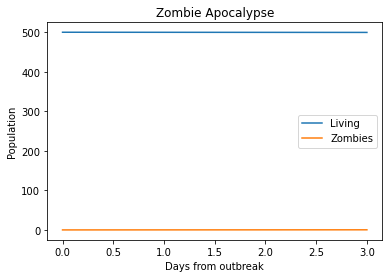

In [4]:
# Plot results
fig, ax = plt.subplots()
l1, = plt.plot(tspan, soln.species[:, 0], label='Living')
l2, = plt.plot(tspan, soln.species[:, 1], label='Zombies')
plt.xlabel('Days from outbreak')
plt.ylabel('Population')
plt.title('Zombie Apocalypse')
plt.legend(loc=0)

## Step 5: Further exercises

1. Try changing the simulation time from 3 to 28 days later. Does the outcome look different? (To re-run the notebook, select **Kernel** then **Restart & Run All** from the menu bar).
2. Try altering the model parameters to see what it would take to fight off the zombies - increase the birth rate? increase the destroy rate?
3. (Advanced) Refer to the [Munz et al. 2009](https://mysite.science.uottawa.ca/rsmith43/Zombies.pdf) for extensions to the model, including adding a latent infection and a quarantine system.